# Forward dynamics of infection on Zachary’s karate club data
Comparison with Fig. 2 in *Ortega et. al*, [Dynamics of epidemics from cavity master equations: Susceptible-infectious-susceptible models](https://doi.org/10.1103/PhysRevE.105.024308)

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, DelimitedFiles, Plots, Statistics, LaTeXStrings, Random
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
import Measurements: value, ±
using Graphs
using JLD2
include("meanfield.jl");

In [7]:
# read matrix of contacts, found at http://konect.cc/networks/ucidata-zachary/
A = readdlm("karate.txt", Bool)
g = IndexedGraph(A);

### MPBP

In [8]:
N = nv(g)  # number of individuals
T = 50     # final time
ΔT = 1.0   # discretization
λ = 0.1    # prob. of transmission
ρ = 0.05   # prob. of recovery

# adjust probabilities and number of discrete time steps to simulate continuous-time behavior
sis = SIS(g, λ*ΔT, ρ*ΔT, floor(Int, T/ΔT))

# prob. of being infected at time zero
# γ = fill(3/N, N)
γ = [i==1 ? 1.0 : 0.0 for i in 1:N]
for i in 1:N
    sis.ϕ[i][1] .= [1-γ[i], γ[i]]
end

# set up MPBP computation
bp = mpbp(sis)
cb = CB_BP(bp);

In [4]:
k = 10
svd_trunc = TruncBond(k)   # maximum matrix size for SVD-based truncation
maxiter = 100
tol = 1e-6

# run MPBP
reset!(bp)
iters, cb = iterate!(bp; cb, svd_trunc, maxiter, tol);

Running MPBP: iter 11 	 Time: 1:08:32
  Δ:                6.640992358253328e-7
  SVD Matrix size:  10

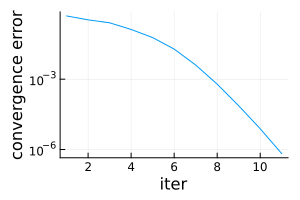

In [5]:
plot(cb.Δs, ylabel="convergence error", xlabel="iter", yaxis=:log10, 
    size=(300,200), label="")

In [6]:
# compute marginals
b_bp = beliefs(bp)
p_bp = [[bb[INFECTED] for bb in b] for b in b_bp];

### SoftMargin MonteCarlo

In [7]:
# instantiate Soft Margin sampler
sms = SoftMarginSampler(bp);

In [8]:
# draw samples
# re-run this cell (but not the one above!) to draw more samples and refine the estimate
rng = MersenneTwister(1)
nsamples_mc = 2*10^5
sample!(sms, nsamples_mc; rng);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:03:213:10


In [9]:
b_mc = marginals(sms)
p_mc = [[value(bb[INFECTED]/sum(bb)) for bb in b] for b in b_mc];

Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:35


In [10]:
# estimate probability of epidemic to die out at time `Tdead`
Tdead = T
ids = findall(!all(x[:,Tdead] .== SUSCEPTIBLE) for x in sms.X)
p_dead_epidemic_mc = 1 - sum(sms.w[ids]) / sum(sms.w)
println("Probability of epidemic being wiped out by time $Tdead (MC estimate): ", 
    p_dead_epidemic_mc)

# discard samples where the epidemic was dead by time `Tdead`
Xnew = sms.X[ids]
wnew = sms.w[ids]
sms_new = SoftMarginSampler(bp, Xnew, wnew)
b_mc_trimmed = marginals(sms_new)
p_mc_trimmed = [[value(bb[INFECTED]/sum(bb)) for bb in b] for b in b_mc_trimmed];

Probability of epidemic being wiped out by time 50 (MC estimate): 0.014735000000000054


Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:30


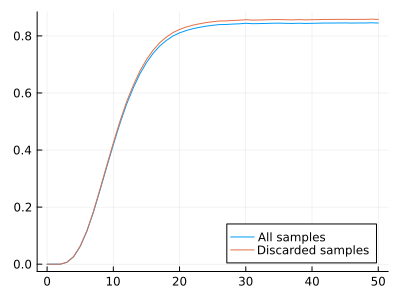

In [11]:
i = 30
plot(0:ΔT:T, value.(p_mc[i]), label="All samples")
plot!(0:ΔT:T, value.(p_mc_trimmed[i]), label="Discarded samples", legend=:bottomright, size=(400,300))

### Discretized mean field methods

In [10]:
using UnPack
fn = "sis_karate_club_network"
data = load("plot_data/"*fn*".jld2")
@unpack T, ΔT, Δt, b_bp, p_bp, p_mc, 
p_dmp_disc, p_ibmf_disc, p_cme_disc, p_dmp, p_cme, p_ibmf, p_gill, nT, c_bp, λ, ρ, svd_trunc = data;

In [11]:
Δt = ΔT
p_dmp_disc, = dmp_disc(T, Δt, bp.g, λ, ρ, γ)     
p_ibmf_disc = ibmf_disc(T, Δt, bp.g, λ, ρ, γ)
p_cme_disc, = cme_disc(T, Δt, bp.g, λ, ρ, γ);

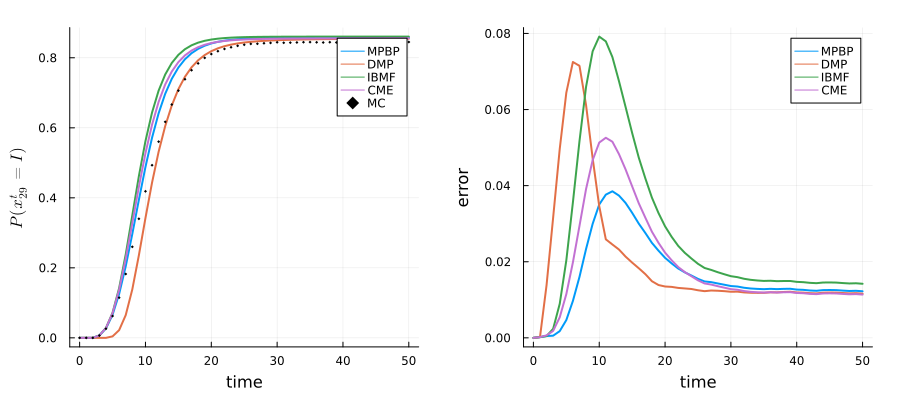

In [12]:
Plots.default(lw=2)
i = 30

pl = plot(xlabel="time", xticks=0:10:T, ylabel=L"P(x_{29}^t=I)", legend=:topright)
plot!(pl, 0:ΔT:T, p_bp[i], label="MPBP")
plot!(pl, 0:ΔT:T, p_dmp_disc[i], label="DMP")
plot!(pl, 0:ΔT:T, p_ibmf_disc[i], label="IBMF")
plot!(pl, 0:Δt:T, p_cme_disc[i], label="CME")
scatter!(pl, 0:ΔT:T, value.(p_mc[i]), c=:black, m=:diamond, ms=1.5, label="MC")

err_bp = [mean(abs(p_bp[i][t]-p_mc[i][t]) for i in 1:N) for t in 1:T+1]
err_dmp_disc = [mean(abs(p_dmp_disc[i][t]-p_mc[i][t]) for i in 1:N) for t in 1:T+1]
err_ibmf_disc = [mean(abs(p_ibmf_disc[i][t]-p_mc[i][t]) for i in 1:N) for t in 1:T+1]
err_cme_disc = [mean(abs(p_cme_disc[i][t]-p_mc[i][t]) for i in 1:N) for t in 1:T+1]

pl_err = plot(xlabel="time", ylabel="error", xticks=0:10:T)
plot!(pl_err, 0:ΔT:T, err_bp, label="MPBP")
plot!(pl_err, 0:ΔT:T, err_dmp_disc, label="DMP")
plot!(pl_err, 0:ΔT:T, err_ibmf_disc, label="IBMF")
plot!(pl_err, 0:Δt:T, err_cme_disc, label="CME")

plot(pl, pl_err, size=(900,400), margin=5Plots.mm)

In [6]:
Plots.default(lw=2)
i = 30

pl = plot(xlabel="time", xticks=0:10:T, ylabel=L"P(x_{29}^t=I)", legend=:bottomright)
plot!(pl, 0:ΔT:T, p_bp[i], label="MPBP")
plot!(pl, 0:ΔT:T, p_dmp_disc[i], label="DMP")
plot!(pl, 0:ΔT:T, p_ibmf_disc[i], label="IBMF")
plot!(pl, 0:Δt:T, p_cme_disc[i], label="CME")
scatter!(pl, 0:ΔT:T, value.(p_mc_trimmed[i]), c=:black, m=:diamond, ms=1.5, label="MC")

err_bp = mean(p_bp .- p_mc_trimmed) .|> value .|> abs
err_dmp_disc = mean(p_dmp_disc .- p_mc_trimmed) .|> value .|> abs
err_ibmf_disc = mean(p_ibmf_disc .- p_mc_trimmed) .|> value .|> abs
pl_err = plot(xlabel="time", ylabel="error", xticks=0:10:T)
plot!(pl_err, 0:ΔT:T, err_bp, label="MPBP")
plot!(pl_err, 0:ΔT:T, err_dmp_disc, label="DMP")
plot!(pl_err, 0:ΔT:T, err_ibmf_disc, label="IBMF")
plot!(pl_err, 0:Δt:T, err_cme_disc, label="CME")

plot(pl, pl_err, size=(900,400), margin=5Plots.mm)

LoadError: UndefVarError: p_mc_trimmed not defined

### Other methods

In [13]:
Δt = 5e-5
nT = 200  # number of time steps to be saved
Δtplot = T/nT;

In [14]:
r_cme, ϕ_cme = cme(T, Δt, bp.g, λ, ρ, γ)
p_cme = [ri[1:end÷nT:end] for ri in r_cme];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


In [15]:
r_dmp, ϕ_dmp = dmp(T, Δt, bp.g, λ, ρ, γ)
p_dmp = [ri[1:end÷nT:end] for ri in r_dmp];

Progress:   0%|▏                                        |  ETA: 0:01:14

λ = 5.0e-6


Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


In [16]:
r_ibmf = ibmf(T, Δt, bp.g, λ, ρ, γ)
p_ibmf = [ri[1:end÷nT:end] for ri in r_ibmf];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


### Continuous MonteCarlo (Gillespie-like)

In [48]:
p_gill,_ = continuous_sis_sampler(sis, T, λ, ρ; nsamples = 10^5, sites=1:N, Δt=Δtplot,
    discard_dead_epidemics=false)
p_gill_trimmed,_ = continuous_sis_sampler(sis, T, λ, ρ; nsamples = 10^5, sites=1:N, Δt=Δtplot,
    discard_dead_epidemics=true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


### MPBP with smaller $\Delta T$

In [160]:
# ΔT2 = ΔT   # discretization
# sis = SIS(g, λ*ΔT2, ρ*ΔT2, floor(Int, T/ΔT2))

# # prob. of being infected at time zero
# for i in 1:N
#    if i == 1
#         sis.ϕ[i][1] .= [0.0, 1.0]   # node 1 is infected at time zero
#     else
#         sis.ϕ[i][1] .= [1.0, 0.0]   # all other nodes start as susceptible
#     end
# end

# # set up MPBP computation
# bp2 = mpbp(sis)
# cb2 = CB_BP(bp2);

In [161]:
# k2 = 6
# svd_trunc = TruncBond(k2)   # maximum matrix size for SVD-based truncation
# maxiter = 100
# tol = 1e-4

# # run MPBP
# reset!(bp2)
# iters, cb2 = iterate!(bp2; cb=cb2, svd_trunc, maxiter, tol);

In [162]:
# plot(cb2.Δs, ylabel="convergence error", xlabel="iter", yaxis=:log10, 
#     size=(300,200), label="")

In [163]:
# # compute marginals
# b_bp2 = beliefs(bp2)
# p_bp2 = [[bb[INFECTED] for bb in b] for b in b_bp2];

### Plots

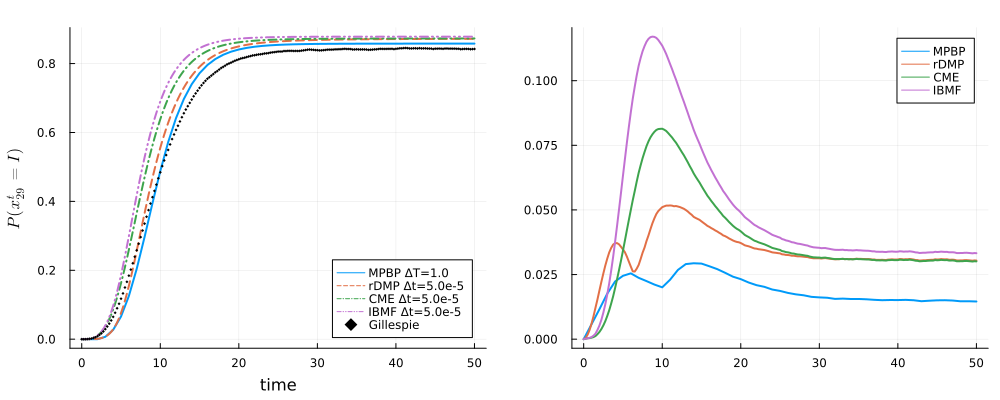

In [17]:
Plots.default(lw=2)
i = 30

pl = plot(xlabel="time", xticks=0:10:T, ylabel=L"P(x_{29}^t=I)", legend=:bottomright)
plot!(pl, 0:ΔT:T, p_bp[i], label="MPBP ΔT=$(ΔT)")
plot!(pl, 0:Δtplot:T, p_dmp[i], ls=:dash, label="rDMP Δt=$(Δt)")
plot!(pl, 0:Δtplot:T, p_cme[i], ls=:dashdot, label="CME Δt=$(Δt)")
plot!(pl, 0:Δtplot:T, p_ibmf[i], ls=:dashdotdot, label="IBMF Δt=$(Δt)")

plot!(pl, 0:Δtplot:T, p_gill[i], label="Gillespie", m=:diamond, st=:scatter, ms=1.5,
    c=:black, msc=:auto)
plot!(pl, size=(1000,400), margin=5Plots.mm, legend=:bottomright)

err_bp = [mean(abs(p_bp[i][t]-p_gill[i][1:floor(Int, ΔT/Δtplot):end][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_dmp = [mean(abs(p_dmp[i][t]-p_gill[i][t]) for i in 1:N) for t in eachindex(p_gill[1])]
err_cme = [mean(abs(p_cme[i][t]-p_gill[i][t]) for i in 1:N) for t in eachindex(p_gill[1])]
err_ibmf = [mean(abs(p_ibmf[i][t]-p_gill[i][t]) for i in 1:N) for t in eachindex(p_gill[1])]

pl_err = plot(0:ΔT:T, err_bp, label="MPBP")
plot!(pl_err, 0:Δtplot:T, err_dmp, label="rDMP")
plot!(pl_err, 0:Δtplot:T, err_cme, label="CME")
plot!(pl_err, 0:Δtplot:T, err_ibmf, label="IBMF")

plot(pl, pl_err)

In [18]:
Plots.default(lw=2)
i = 30

pl = plot(xlabel="time", xticks=0:10:T, ylabel=L"P(x_{29}^t=I)", legend=:bottomright)
plot!(pl, 0:ΔT:T, p_bp[i], label="MPBP ΔT=$(ΔT)")
plot!(pl, 0:Δtplot:T, p_dmp[i], ls=:dash, label="rDMP Δt=$(Δt)")
plot!(pl, 0:Δtplot:T, p_cme[i], ls=:dashdot, label="CME Δt=$(Δt)")
plot!(pl, 0:Δtplot:T, p_ibmf[i], ls=:dashdotdot, label="IBMF Δt=$(Δt)")

plot!(pl, 0:Δtplot:T, p_gill_trimmed[i], label="Gillespie", m=:diamond, st=:scatter, ms=1.5, msc=:auto, c=:black)
plot!(pl, size=(1000,400), margin=5Plots.mm, legend=:bottomright)

err_bp_trimmed = [mean(abs(p_bp[i][t]-p_gill_trimmed[i][1:floor(Int, ΔT/Δtplot):end][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_dmp_trimmed = [mean(abs(p_dmp[i][t]-p_gill_trimmed[i][t]) for i in 1:N) for t in eachindex(p_gill_trimmed[1])]
err_cme_trimmed = [mean(abs(p_cme[i][t]-p_gill_trimmed[i][t]) for i in 1:N) for t in eachindex(p_gill_trimmed[1])]
err_ibmf_trimmed = [mean(abs(p_ibmf[i][t]-p_gill_trimmed[i][t]) for i in 1:N) for t in eachindex(p_gill_trimmed[1])]

pl_err = plot(0:ΔT:T, err_bp_trimmed, label="MPBP")
plot!(pl_err, 0:Δtplot:T, err_dmp_trimmed, label="rDMP")
plot!(pl_err, 0:Δtplot:T, err_cme_trimmed, label="CME")
plot!(pl_err, 0:Δtplot:T, err_ibmf_trimmed, label="IBMF")

plot(pl, pl_err)

LoadError: UndefVarError: p_gill_trimmed not defined

In [52]:
c_bp = autocovariances(bp);

In [34]:
include("../../telegram/notifications.jl");
@telegram "karate"

In [ ]:
jldsave("plot_data/sis_karate_club_network.jld2"; T, ΔT, Δt, b_bp, p_bp, p_mc, 
    p_dmp_disc, p_ibmf_disc, p_cme_disc, p_dmp, p_cme, p_ibmf, p_gill, nT, c_bp, λ, ρ, svd_trunc);